#### Computational Test

#### Config

In [1]:
## load some packages
# model
from models.hankv2 import HANK
from toolkit.irfs import *

# general
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from cmcrameri import cm as cmc
import seaborn as sns
import pandas as pd
import numpy as np
import cmcrameri

## config
plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
        'figure.titlesize': 'medium',
        'figure.labelsize': 'medium',
        'axes.titlesize': 'medium',
    })
cmap = 'cmc.batlow'
sns.set_palette(sns.color_palette(cmap, n_colors=7))
save = True

#### Time Horizons

In [18]:
## config
labels = {   # keys for labeling
        'epsA': '$A$', 'epspsi': r'$\psi$', 'epspsiW': r'$\psi_W$', 'epsg': '$g$', 'epsxi': r'$\xi$', 'epstauP': r'$\tau^P$', 'epseta': r'$\eta$',  # shocks
        'pi': r'$\pi$', 'W': '$W$', 'M': '$M$', 'D': '$D$', 'R': '$R$', 'I': '$I$', 'tauL': r'$\tau^L$',  # prices
        'curlC': '$C$', 'curlB': '$B$',  # hh aggs
        'Y': '$Y$', 'N': '$N$', 'B': '$B$', 'G': '$G$', 'L': '$L$',  # econ aggs
    }
Tcomp = len(pd.read_csv('data/data.csv'))  # check this number of periods in the irf
Tbaseline = 1500
outputs = np.array(['Y', 'pi', 'I', 'N', 'B', 'curlC', 'W'])  # outputs we estimate off of

## intialize model
mod_pars = {
        'gamma': 4., 'chi': 2.,  # household parameters, beta and phi are chosen in calibration
        'N_z': 7, 'rho_z': 0.963, 'sigma_z': 0.134,  # household state transitions
        'kappa': 0.1,  # philips curve
        'kappa_W': 0.1,
        'rho_B': 0.93, 'omega_pi': 1.5, 'omega_Y': 0.,  # govt parameters
        'A': 1., 'psi': 1.2, 'psiW': 1.2, 'g': 0.201, 'xi': 1., 'tauP': 1.18, 'eta': 0.081,  # shock steady states
        'epsA': 1., 'epspsi': 1., 'epspsiW': 1., 'epsg': 1., 'epsxi': 1., 'epstauP': 1., 'epseta': 1.,
        'pi': 1., 'B': 0.577,  # variable steady states we define (otherwise model can't be solved)
        'I': 1.005, 'Y': 1.,  # varaible steady states we target
        'N_a': 501, 'a_min': 0, 'a_max': 50,  # grid states
    }
hank = HANK(**mod_pars)

## solve steady state
free = ['beta', 'phi']
endog = ['R', 'G', 'tauL', 'N', 'M', 'D', 'piW', 'L', 'curlN', 'curlC', 'curlB']
markets = {m: HANK.markets[m] for m in ['mkt3', 'mkt4']}  # the other markets clear by definition or by an analytic form
V_a0 = (hank.a_grid[:, None] * (hank.I - 1) + hank.z_grid)**(-hank.gamma)
X0 = np.array([0.9, 0.1])
hank.solve_ss(free, endog, V_a0, X0, markets=markets)
assert np.isclose(hank.curlC + hank.G - hank.Y, 0)  # walras

## parameters
## run instead of estiation, loads from file
res_df = pd.read_csv('data/bayes_results.csv', index_col=0)
shock_pars = res_df['mean'].to_dict()  # save the means to a dictaionary
rhos = {p.split('_')[1]: v for p, v in shock_pars.items() if p.startswith('rho')}
sigmas = {p.split('_')[1]: v for p, v in shock_pars.items() if p.startswith('sigma')}

## basline irfs
G, _ = hank.solve_G(Tbaseline, ha=True, h=1e-4)
baseline_irfs = all_shock_irfs(G, rhos, Tbaseline, sigmas)
baseline_irfs = {
        Z: {X: irf[:Tcomp] for X, irf in X_irf.items()}
            for Z, X_irf in baseline_irfs.items()
    }

## loop and get differences
ts = 25 * np.arange(4, 41)  # check at these T values
diffs = {Z: {X: np.empty_like(ts, dtype=float) for X in outputs} for Z in hank.shocks}  # keep differences
for i, t in enumerate(ts):
    ## solve for new irfs
    G, _ = hank.solve_G(t, ha=True, h=1e-4)
    tirfs = all_shock_irfs(G, rhos, t, sigmas)

    ## compare to the old ones
    for Z in hank.shocks:
        for X in outputs:
            long_irf = np.hstack((tirfs[Z][X], np.zeros(Tcomp)))[:Tcomp]
            irf_diff = long_irf - baseline_irfs[Z][X]
            irf_diff /= hank.__getattribute__(X)
            diffs[Z][X][i] = np.sqrt((irf_diff**2).sum())

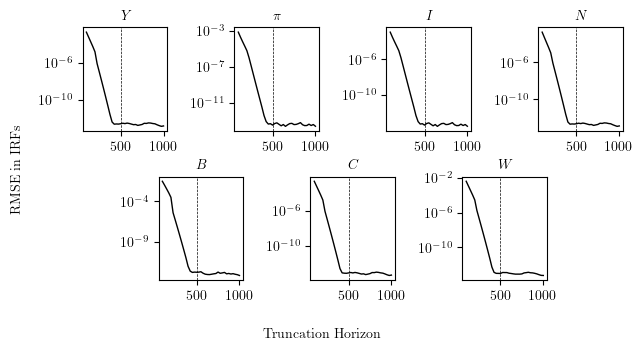

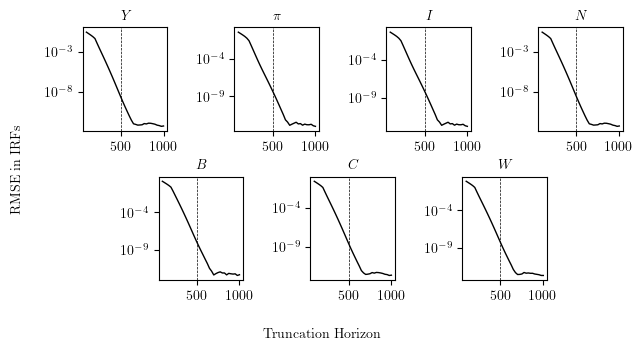

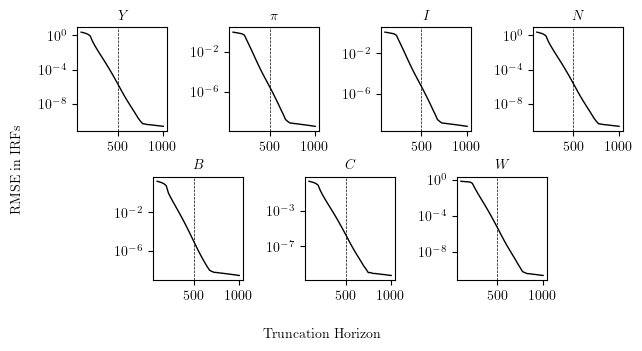

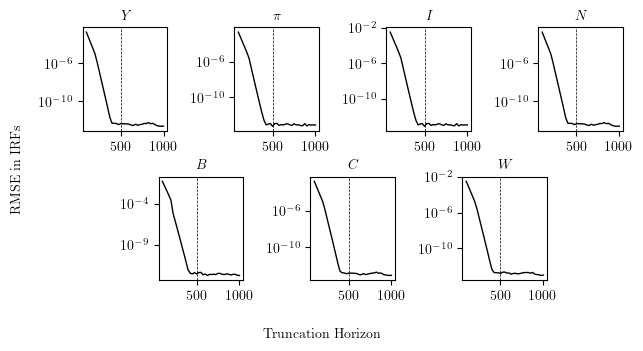

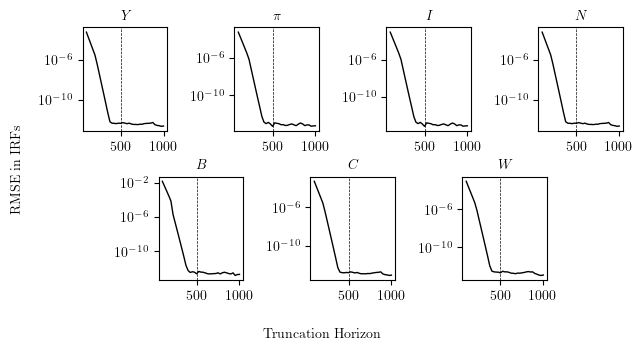

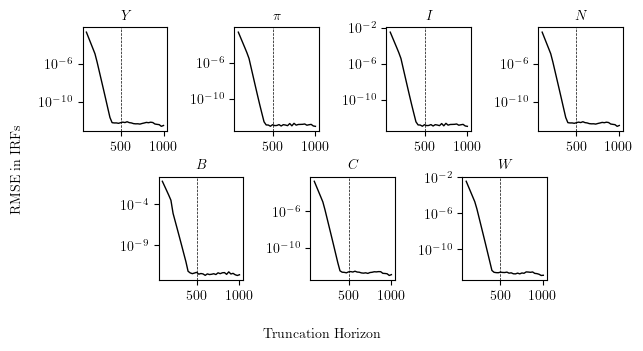

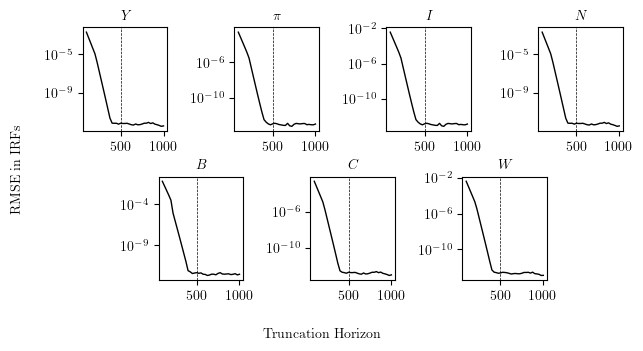

In [28]:
## loop and plot for each shocks
for Z in hank.shocks:
    # setup plot
    fig, axs = plt.subplots(2, 4)
    fig.set_figwidth(6.5)
    fig.set_figheight(3.5)
    fig.supylabel(f'RMSE in IRFs')
    fig.supxlabel('Truncation Horizon')
    
    # loop and plot diff
    for j, (X, diff) in enumerate(diffs[Z].items()):
        ax = axs.take(j)
        ax.set_title(labels[X])
        ax.set_yscale('log')
        ax.plot(ts, diff, c='k', ls='-', lw=1)
        ax.axvline(500, c='k', ls='--', lw=0.5)

    # fnal things
    fig.tight_layout(h_pad=0.4)
    axs.take(-1).set_axis_off()
    xs = (axs[-1, -1].get_position().x1 - axs[-1, -2].get_position().x1) / 2
    for i in range(3):
        (x0, y0), (x1, y1) = axs[-1, i].get_position().get_points()
        axs[-1, i].set_position([x0 + xs, y0, x1 - x0, y1 - y0])
    fig.savefig(f'paper/figures/{Z[3:]}_comp_err.pgf')